# Unsupervised + CNN

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Charger le CSV contenant les prédictions
df = pd.read_csv("dataset_predicted.csv")

print("✔ CSV chargé :")
display(df.head())

✔ CSV chargé :


,hpc_500,pfc_500,predicted_state
0,62.844705,51.656355,1
1,137.740828,57.758723,1
2,80.019974,23.671246,1
3,89.810803,39.607111,1
4,58.157103,64.048580,1


In [14]:
# 2. faire des trucs importants genre les nan et mettre en entier
unique_states = df['predicted_state'].unique()
print("\nÉtats prédits présents dans le dataset :", unique_states)
df = df.dropna(subset=['predicted_state']).copy()
df['predicted_state'] = df['predicted_state'].astype(int)



États prédits présents dans le dataset : [1 3 5 4]


In [15]:
unique_states = sorted(df['predicted_state'].unique())
print("États détectés :", unique_states)


États détectés : [np.int64(1), np.int64(3), np.int64(4), np.int64(5)]


In [16]:
# 🔹 Splitter les données par état
df_wake         = df[df['predicted_state'] == 1].copy()
df_nrem         = df[df['predicted_state'] == 3].copy()
df_intermediate = df[df['predicted_state'] == 4].copy()
df_rem          = df[df['predicted_state'] == 5].copy()

# 🔹 Dictionnaire final
datasets_by_state = {
    1: df_wake,
    3: df_nrem,
    4: df_intermediate,
    5: df_rem
}

# 🔹 Récapitulatif
for state, subset in datasets_by_state.items():
    print(f"État {state} → {len(subset)} échantillons")


État 1 → 418000 échantillons
État 3 → 895000 échantillons
État 4 → 500 échantillons
État 5 → 58000 échantillons


In [27]:
df_intermediate.head()

,hpc_500,pfc_500,predicted_state
436500,160.205595,-15.411299,4
436501,154.406812,-28.065043,4
436502,128.802869,7.049903,4
436503,146.038176,24.206325,4
436504,174.966405,75.277028,4


# Unsupervised

# NREM

In [28]:
df = df_nrem.copy()


## librairies

In [30]:
from scipy.signal import welch
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap
import hdbscan


## paramètres (à ajuster)

In [31]:
FS = 500 # fréquence d'échantillonnage
WINDOW_SEC = 5 # durée de fenêtre en secondes
STEP_SEC = 2.5 # pas (overlap), 50% overlap -> 2.5s
NFFT = 2048 # pour welch, ou None pour choix automatique

## bandes (définition Hz)

In [33]:
BANDS = {
'delta': (0.5, 4),
'theta': (4, 8),
'alpha': (8, 12),
'sigma': (12, 15),
'beta': (15, 30),
'gamma': (30, 80)
}

## HDBSCAN paramètres de départ

In [32]:
# HDBSCAN params (bon point de départ)
HDBSCAN_PARAMS = {
'min_cluster_size': 50, # minimum points for a cluster
'min_samples': 10, # plus robuste au bruit
'cluster_selection_method': 'eom'
}

## fonctions

In [34]:
def load_predicted_csv(path="dataset_predicted.csv"):
  df = pd.read_csv(path)
  # Keep only required columns if present
  cols = ['hpc_500', 'pfc_500', 'predicted_state']
  for c in cols:
    if c not in df.columns:
      print(f"Colonne requise manquante: {c}")
  # drop NaN states and convert to int
  df = df.dropna(subset=['predicted_state']).copy()
  df['predicted_state'] = df['predicted_state'].astype(int)
  return df

def window_dataframe(df, fs=FS, window_sec=WINDOW_SEC, step_sec=STEP_SEC):
  win_len = int(window_sec * fs)
  step = int(step_sec * fs)
  n = len(df)
  windows = []
  starts = []
  ends = []
  for start in range(0, n - win_len + 1, step):
    end = start + win_len
    windows.append(df.iloc[start:end])
    starts.append(start)
    ends.append(end)
  return windows, np.array(starts), np.array(ends)


def band_power_from_psd(freqs, psd, fmin, fmax):
  idx = np.logical_and(freqs >= fmin, freqs <= fmax)
  if np.sum(idx) == 0:
    return 0.0
  return np.trapz(psd[idx], freqs[idx])


def extract_features_from_window(win_df, fs=FS, nfft=NFFT, bands=BANDS):
  # win_df expected to have 'hpc_500' and 'pfc_500'
  h = win_df['hpc_500'].values
  p = win_df['pfc_500'].values
  # Time-domain features for both channels
  feats = {}
  for label, sig in [('hpc', h), ('pfc', p)]:
    feats[f'{label}_rms'] = np.sqrt(np.mean(sig**2))
    feats[f'{label}_var'] = np.var(sig)
    feats[f'{label}_skew'] = float(skew(sig))
    feats[f'{label}_kurt'] = float(kurtosis(sig))
    feats[f'{label}_zcr'] = float(np.mean(np.abs(np.diff(np.sign(sig)))>0))


    # PSD
    freqs, psd = welch(sig, fs=fs, nperseg=min(len(sig), 512), nfft=nfft)
    total_power = np.trapz(psd, freqs) + 1e-12
    feats[f'{label}_total_power'] = total_power
    # Band powers
    for band_name, (fmin, fmax) in bands.items():
      feats[f'{label}_bp_{band_name}'] = band_power_from_psd(freqs, psd, fmin, fmax)
      feats[f'{label}_bp_{band_name}_rel'] = feats[f'{label}_bp_{band_name}'] / total_power


  # Cross-channel features
  feats['cross_corr'] = float(np.corrcoef(h, p)[0,1])
  # Ratios
  # Compute delta/theta ratio for hpc and pfc
  for label in ['hpc', 'pfc']:
    delta = feats[f'{label}_bp_delta']
    theta = feats[f'{label}_bp_theta']
    feats[f'{label}_delta_theta'] = delta / (theta + 1e-12)
    feats[f'{label}_delta_beta'] = delta / (feats[f'{label}_bp_beta'] + 1e-12)


  return feats

## Main pipeline

In [35]:
def build_feature_matrix(df_nrem, save_features_csv=True, verbose=True):
    # df_nrem: dataframe with HPC/PFC only for NREM
    if verbose:
        print('Fenêtrage...')
    windows, starts, ends = window_dataframe(df_nrem, fs=FS, window_sec=WINDOW_SEC, step_sec=STEP_SEC)
    features = []
    for i, win in enumerate(windows):
        feats = extract_features_from_window(win, fs=FS)
        feats['window_idx'] = i
        feats['start_sample'] = starts[i]
        feats['end_sample'] = ends[i]
        # You can also store the predicted_state majority inside the window
        feats['state_mode'] = int(win['predicted_state'].mode()[0]) if 'predicted_state' in win.columns else np.nan
        features.append(feats)
        if verbose and i % 500 == 0 and i > 0:
            print(f"  -> {i} windows computed")

    features_df = pd.DataFrame(features)
    if save_features_csv:
        features_df.to_csv('features_nrem_windows.csv', index=False)
        if verbose:
            print('Features saved to features_nrem_windows.csv')
    return features_df

def preprocess_and_reduce(features_df, n_components_pca=10, verbose=True):
    # Drop non-feature cols
    meta_cols = ['window_idx', 'start_sample', 'end_sample', 'state_mode']
    feat_cols = [c for c in features_df.columns if c not in meta_cols]

    X = features_df[feat_cols].fillna(0).values
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)

    pca = PCA(n_components=n_components_pca, random_state=42)
    X_pca = pca.fit_transform(Xs)
    if verbose:
        print('Explained variance ratio (PCA):', np.round(pca.explained_variance_ratio_[:5], 4))
    return Xs, X_pca, feat_cols, scaler, pca

def run_hdbscan(X_embedded, min_cluster_size=HDBSCAN_PARAMS['min_cluster_size'], min_samples=HDBSCAN_PARAMS['min_samples']):
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, cluster_selection_method='eom')
    labels = clusterer.fit_predict(X_embedded)
    return labels, clusterer

def profile_clusters(features_df, cluster_labels, feat_cols, top_k=5, output_prefix='cluster_profile'):
    dfp = features_df.copy()
    dfp['cluster'] = cluster_labels
    summary = dfp.groupby('cluster')[feat_cols].mean()
    summary.to_csv(f'{output_prefix}_mean_features.csv')
    print(f'Cluster profile saved to {output_prefix}_mean_features.csv')
    return summary

## run all (exemple)

NREM length (samples): 895000
Fenêtrage...


/tmp/ipython-input-3998603870.py:51: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_power = np.trapz(psd, freqs) + 1e-12
/tmp/ipython-input-3998603870.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[idx], freqs[idx])
/tmp/ipython-input-3998603870.py:51: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_power = np.trapz(psd, freqs) + 1e-12
/tmp/ipython-input-3998603870.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[idx], freqs[idx])
/tmp/ipython-input-3998603870.py:51: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integrati

  -> 500 windows computed


/tmp/ipython-input-3998603870.py:51: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_power = np.trapz(psd, freqs) + 1e-12
/tmp/ipython-input-3998603870.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[idx], freqs[idx])
/tmp/ipython-input-3998603870.py:51: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_power = np.trapz(psd, freqs) + 1e-12
/tmp/ipython-input-3998603870.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[idx], freqs[idx])
/tmp/ipython-input-3998603870.py:51: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integrati

Features saved to features_nrem_windows.csv
Features shape: (715, 45)
Explained variance ratio (PCA): [0.4097 0.1211 0.0767 0.0584 0.0451]
UMAP computed
HDBSCAN found clusters, unique labels: [-1  0  1  2]
Saved features_nrem_with_clusters.csv
Cluster profile saved to cluster_profile_mean_features.csv


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,hpc_rms,hpc_var,hpc_skew,hpc_kurt,hpc_zcr,hpc_total_power,hpc_bp_delta,hpc_bp_delta_rel,hpc_bp_theta,hpc_bp_theta_rel,...,pfc_bp_sigma_rel,pfc_bp_beta,pfc_bp_beta_rel,pfc_bp_gamma,pfc_bp_gamma_rel,cross_corr,hpc_delta_theta,hpc_delta_beta,pfc_delta_theta,pfc_delta_beta
cluster,,,,,,,,,,,,,,,,,,,,,
-1,111.366675,11843.359537,0.074473,0.096971,0.072373,11832.111512,3912.525486,0.321094,3104.848668,0.268472,...,0.017398,644.462717,0.038848,476.295179,0.030808,0.328686,1.533625,4.637204,8.040561,69.858254
0,98.863030,9181.249724,0.066864,0.289311,0.081207,8942.562713,2485.808630,0.276283,2540.825390,0.283592,...,0.015216,514.592530,0.031031,455.640204,0.028003,0.320837,1.036537,3.169867,3.693279,26.666779
1,106.764212,10817.628239,0.110218,0.240426,0.072015,10579.379417,4079.554003,0.385111,2543.627154,0.241417,...,0.005153,532.241803,0.009263,416.052847,0.007185,0.340466,1.693560,5.762756,9.425948,92.845757
2,120.606908,13960.025227,0.121929,0.128774,0.064035,14043.321553,6501.880249,0.457241,2915.408112,0.209111,...,0.003848,672.769865,0.006024,411.962463,0.003761,0.411062,2.350416,7.258051,15.121495,146.540686


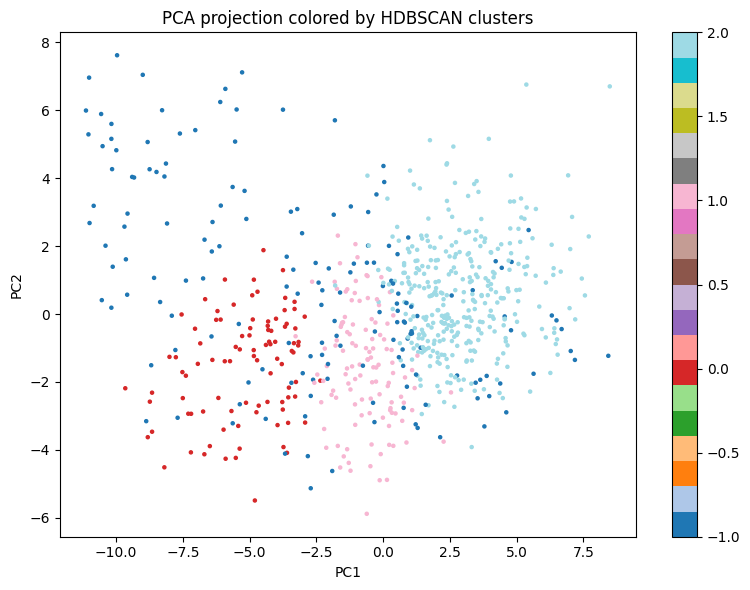

Saved nrem_cluster_windows.csv (one row per window)
Saved nrem_with_cluster_per_sample.csv

Pipeline completed. Outputs:
 - features_nrem_windows.csv
 - features_nrem_with_clusters.csv
 - nrem_cluster_windows.csv
 - nrem_with_cluster_per_sample.csv
 - pca_clusters.png

If hdbscan is not installed, run: pip install hdbscan


In [36]:
if __name__ == '__main__':
    # 1) Charger dataset_predicted.csv et garder uniquement NREM
    df_all = load_predicted_csv('dataset_predicted.csv')
    df_nrem = df_all[df_all['predicted_state'] == 3].reset_index(drop=True)
    print('NREM length (samples):', len(df_nrem))

    # 2) Build feature matrix (windows)
    features_df = build_feature_matrix(df_nrem, save_features_csv=True, verbose=True)
    print('Features shape:', features_df.shape)

    # 3) Preprocess (scaling) + PCA
    Xs, X_pca, feat_cols, scaler, pca = preprocess_and_reduce(features_df, n_components_pca=10, verbose=True)

    # 4) Choose embedding for clustering: use PCA components or UMAP if available

    reducer = umap.UMAP(n_components=2, random_state=42)
    X_emb = reducer.fit_transform(Xs)
    print('UMAP computed')


    # 5) Run HDBSCAN on embedding
    labels, clusterer = run_hdbscan(X_emb, min_cluster_size=HDBSCAN_PARAMS['min_cluster_size'], min_samples=HDBSCAN_PARAMS['min_samples'])
    print('HDBSCAN found clusters, unique labels:', np.unique(labels))

    # 6) Save cluster labels with features
    features_df['cluster'] = labels
    features_df.to_csv('features_nrem_with_clusters.csv', index=False)
    print('Saved features_nrem_with_clusters.csv')

    # 7) Profile clusters
    summary = profile_clusters(features_df, labels, feat_cols)
    display(summary.head())

    # 8) Visualization: scatter PCA 2D colored by cluster
    plt.figure(figsize=(8,6))
    if X_pca.shape[1] >= 2:
        plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, s=5, cmap='tab20')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.title('PCA projection colored by HDBSCAN clusters')
        plt.colorbar()
        plt.tight_layout()
        plt.savefig('pca_clusters.png', dpi=150)
        plt.show()

    # 9) Optional: build a hypnogram-like series of cluster labels over time (one label per window)
    win_mode = features_df[['window_idx', 'start_sample', 'end_sample', 'cluster']]
    win_mode.to_csv('nrem_cluster_windows.csv', index=False)
    print('Saved nrem_cluster_windows.csv (one row per window)')

    # 10) Back-project cluster labels to sample-level if desired (fills window length with cluster id)
    cluster_per_sample = np.full(len(df_nrem), -1, dtype=int)
    win_len = int(WINDOW_SEC*FS)
    step = int(STEP_SEC*FS)
    for _, row in win_mode.iterrows():
        s = int(row['start_sample'])
        e = int(row['end_sample'])
        cluster_per_sample[s:e] = int(row['cluster'])

    # Save as CSV aligned with original samples
    df_nrem_out = df_nrem.copy()
    df_nrem_out['cluster_window'] = cluster_per_sample
    df_nrem_out.to_csv('nrem_with_cluster_per_sample.csv', index=False)
    print('Saved nrem_with_cluster_per_sample.csv')

    print('\nPipeline completed. Outputs:')
    print(' - features_nrem_windows.csv')
    print(' - features_nrem_with_clusters.csv')
    print(' - nrem_cluster_windows.csv')
    print(' - nrem_with_cluster_per_sample.csv')
    print(' - pca_clusters.png')
    print('\nIf hdbscan is not installed, run: pip install hdbscan')